In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import nutpie
import arviz as az
import pytensor.tensor as at
import matplotlib.pyplot as plt
from util import build_XY

In [2]:
gp_samples = az.InferenceData.from_netcdf("./mogp.nc")

In [4]:
n_outputs = 3
country_mapping = {"US":0, "UK":1, "AU":2} 
M = 91
x_new = np.linspace(0, M, M)[:, None]
X_new, _, _ = build_XY([x_new for idx in range(n_outputs)])
X_new.shape

(273, 2)

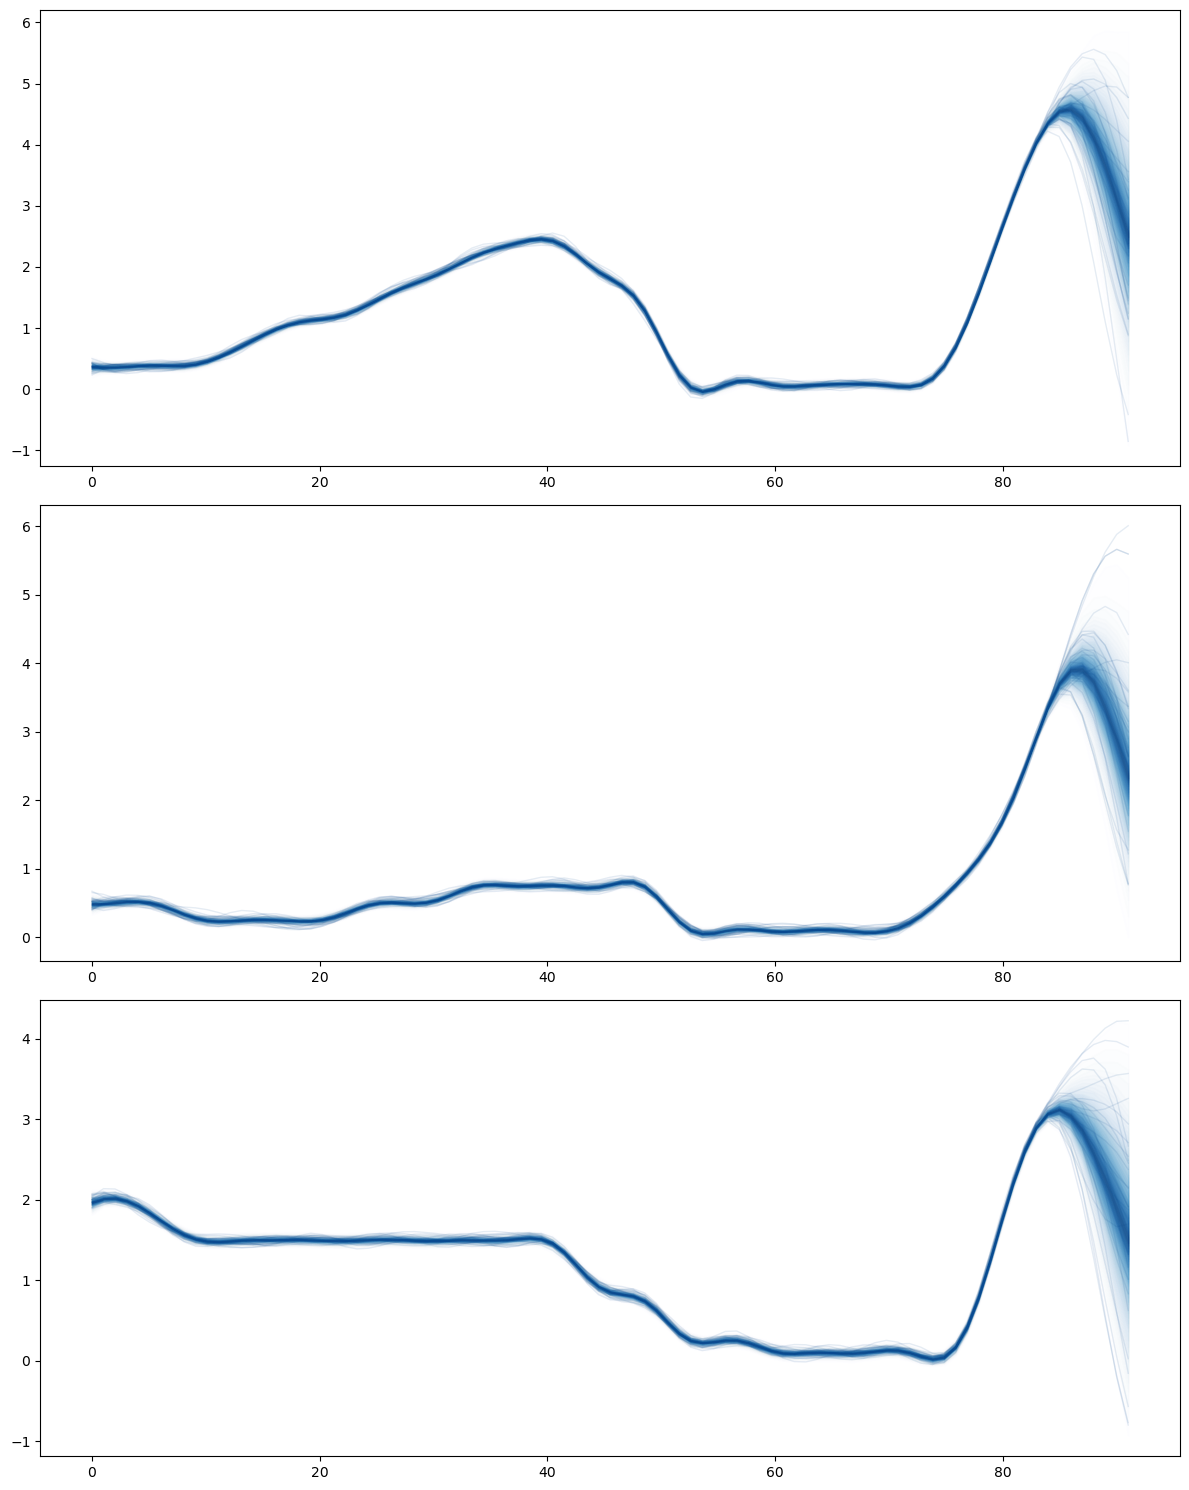

In [5]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(n_outputs,1, figsize=(12,15))

for idx, country in enumerate(country_mapping.keys()):
    # Prediction
    plot_gp_dist(axes[idx], f_pred[:,M*idx:M*(idx+1)], 
                 X_new[M*idx:M*(idx+1),0], 
                 palette="Blues", fill_alpha=0.1, samples_alpha=0.1)    
    # Train data points
#     cond = adf["country"] == country
#     axes[idx].scatter(adf.loc[cond, "x"], adf.loc[cond, "rate"], color='r')
#     axes[idx].set_title(country)
plt.tight_layout()

In [7]:
dates_idx = pd.DataFrame({"date":pd.date_range("2016-01-01", "2023-07-01", freq='MS')}).reset_index()
dates_idx = dates_idx.rename(columns={"index":"x"})
print(dates_idx.shape)
dates_idx.head()

(91, 2)


,x,date
0,0,2016-01-01
1,1,2016-02-01
2,2,2016-03-01
3,3,2016-04-01
4,4,2016-05-01


In [8]:
pred_results = {}

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)

for idx, country in enumerate(country_mapping.keys()):
    # Prediction
    print(idx, country)
    y_ = f_pred[:,M*idx:M*(idx+1)]
    y_["preds_dim_2"] = ("preds_dim_2", dates_idx["date"])
    pred_results[country] = y_
    y_.to_netcdf(f"../data/{country}.nc")
    
    # Save prediction into csv files
    df_data = pd.DataFrame(x_new, columns=["x_new"])
    df_data["Date"] = pred_results[country].mean(dim="draw")['preds_dim_2']
    df_data["Mean"] = pred_results[country].mean(dim="draw").values
    df_data["Q90"] = pred_results[country].quantile(q=0.9, dim="draw").values
    df_data["Q10"] = pred_results[country].quantile(q=0.1, dim="draw").values
    df_data.to_csv(f"../data/prediction_{country}.csv")

0 US
1 UK
2 AU
